Gefundene Zeitreihen mit Kriterien: 264
Top 5 GROW_IDs: ['GROW-80939064354', 'GROW-80952817519', 'GROW-80940657465', 'GROW-80953817666', 'GROW-80931816834']
Zeige Plots für GROW_ID: GROW-80939064354


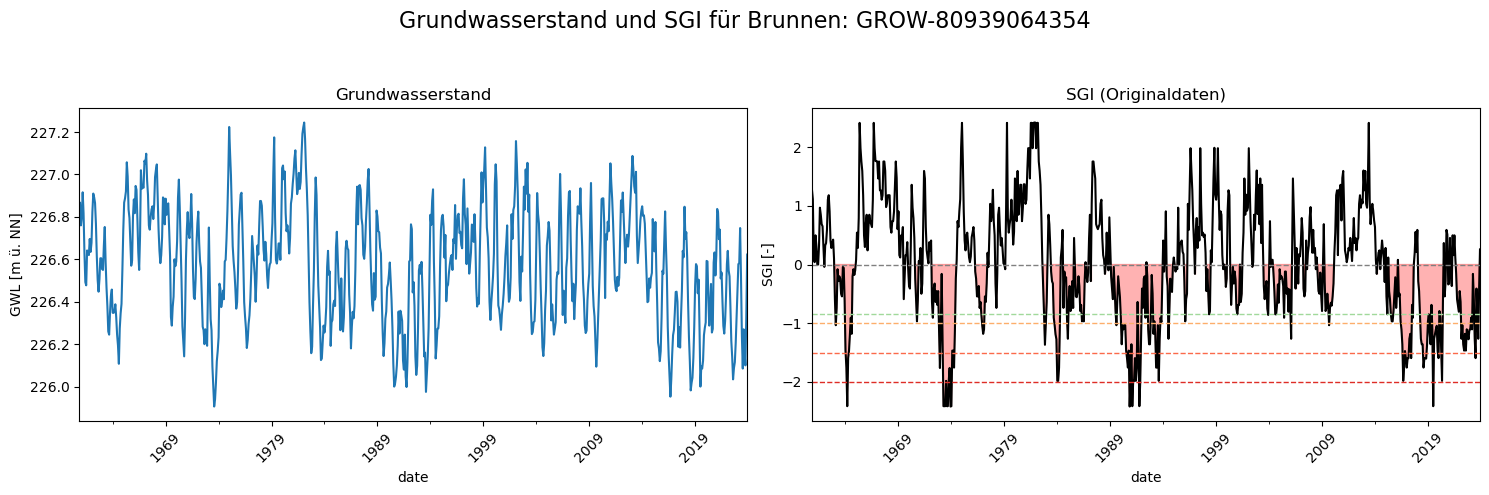

In [ ]:
# 1. Bibliotheken importieren
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import pyarrow.dataset as ds

# 2. Loglevel reduzieren
ps.set_log_level("ERROR")

# 3. Attribute-Datei laden (metadata über die Zeitreihen)
try:
    attr = pd.read_parquet("Daten/grow_attributes.parquet")
except FileNotFoundError:
    print("Fehler: 'Daten/grow_attributes.parquet' nicht gefunden. Stellen Sie sicher, dass die Datei existiert.")
    raise

# 4. Tschechische GROW_IDs mit den gewünschten Kriterien auswählen
attr_filtered = attr[
    (attr["country"] == "CZE") &
    (attr["length_years"] >= 30) &
    (attr["gap_fraction"] == 0.0) &
    (pd.to_datetime(attr["ending_date"]) >= pd.Timestamp("2023-12-31"))
]

# Anzahl passender Zeitreihen anzeigen
print(f"Gefundene Zeitreihen mit Kriterien: {len(attr_filtered)}")

if attr_filtered.empty:
    raise ValueError("Keine passende Zeitreihe für CZ mit ≥30 Jahren, ohne Gaps, bis ≥2023 gefunden.")

# Top 5 GROW_IDs mit längster Laufzeit auswählen
top5_ids = attr_filtered.sort_values("length_years", ascending=False).head(5)["GROW_ID"].tolist()
print("Top 5 GROW_IDs:", top5_ids)

if not top5_ids:
    raise ValueError("Keine GROW_IDs in top5_ids gefunden, obwohl attr_filtered nicht leer war. Überprüfen Sie die Daten.")

# Nur die erste GROW_ID für den Plot auswählen
grow_id_to_plot = top5_ids[0]
print(f"Zeige Plots für GROW_ID: {grow_id_to_plot}")

# 6. Parquet-Dataset selektiv laden für die ausgewählte GROW_ID
try:
    dataset = ds.dataset("Daten/grow_timeseries.parquet", format="parquet")
except Exception as e:
    print(f"Fehler beim Zugriff auf 'Daten/grow_timeseries.parquet': {e}")
    raise

table = dataset.to_table(filter=ds.field("GROW_ID").isin([grow_id_to_plot]), # Filter auf einzelne ID
                         columns=["GROW_ID", "date", "groundwater_level_m_asl"])
ts_df = table.to_pandas()

# 7. Plot vorbereiten
# Jetzt 1 Zeile, 2 Spalten: 1x GWL, 1x SGI (Original)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # Eine Zeile, zwei Spalten
fig.suptitle(f"Grundwasserstand und SGI für Brunnen: {grow_id_to_plot}", fontsize=16)

# Definition der Dürreschwellen und Farben für SGI-Plot
thresholds = [-0.84, -1.00, -1.50, -2.00]
colors = ["#a1d99b", "#fdae6b", "#fb6a4a", "#de2d26"] # Grün bis Rot

# 8. Datenverarbeitung für die ausgewählte GROW_ID
brunnen_df = ts_df[ts_df["GROW_ID"] == grow_id_to_plot].copy()

if brunnen_df.empty:
    print(f"Keine Zeitreihendaten für die ausgewählte GROW_ID {grow_id_to_plot} gefunden.")
    ax1.set_visible(False)
    ax2.set_visible(False)
    plt.show()
    exit() # Beenden, wenn keine Daten für die ID da sind

serie_raw = brunnen_df[["date", "groundwater_level_m_asl"]].dropna()
serie_raw.set_index("date", inplace=True)
serie_raw.index = pd.to_datetime(serie_raw.index)

if serie_raw.empty or len(serie_raw.squeeze().unique()) < 2 :
    print(f"Nicht genügend Daten oder keine Varianz im Grundwasserstand für {grow_id_to_plot}.")
    ax1.set_visible(False)
    ax2.set_visible(False)
    plt.show()
    exit() # Beenden

serie = serie_raw.squeeze()
serie.name = f"GWL [{grow_id_to_plot}]"

serie_for_sgi = serie.copy()

if len(serie_for_sgi.dropna()) < 12:
    print(f"Weniger als 12 Datenpunkte für SGI-Berechnung bei {grow_id_to_plot}.")
    ax1.set_visible(False)
    ax2.set_visible(False)
    plt.show()
    exit() # Beenden

try:
    sgi_original = ps.stats.sgi(serie_for_sgi)
    if sgi_original.empty or sgi_original.isnull().all():
        print(f"SGI-Berechnung ergab leere oder nur NaN-Werte für {grow_id_to_plot}.")
        ax1.set_visible(False)
        ax2.set_visible(False)
        plt.show()
        exit() # Beenden
except Exception as e:
    print(f"Fehler bei SGI-Berechnung für {grow_id_to_plot}: {e}.")
    ax1.set_visible(False)
    ax2.set_visible(False)
    plt.show()
    exit() # Beenden
    
# --- Plots für die ausgewählte GROW_ID ---

# Plot 1: Grundwasserstand (GWL) - ohne Legende
serie.plot(ax=ax1) # Kein 'label' mehr
ax1.set_ylabel("GWL [m ü. NN]")
ax1.set_title(f"Grundwasserstand") # ID ist im suptitle
ax1.tick_params(axis='x', rotation=45)

# Plot 2: SGI (Originaldaten) - ohne Legende
sgi_original.plot(ax=ax2, color="black") # Kein 'label' mehr
ax2.axhline(0, linestyle="--", color="gray", linewidth=1)
for t, c in zip(thresholds, colors):
    ax2.axhline(t, linestyle="--", color=c, linewidth=1)

droughts_original = sgi_original.copy()
if not droughts_original.isnull().all():
    droughts_original_fill = droughts_original.copy()
    droughts_original_fill[droughts_original_fill > 0] = 0
    ax2.fill_between(sgi_original.index, 0, droughts_original_fill.fillna(0),
                     where=droughts_original_fill < 0,
                     color="red", alpha=0.3) # Kein 'label' mehr

ax2.set_ylabel("SGI [-]")
ax2.set_title(f"SGI (Originaldaten)") # ID ist im suptitle
ax2.tick_params(axis='x', rotation=45)

# Gesamtlayout anpassen und anzeigen
plt.tight_layout(rect=[0, 0, 1, 0.93]) # Ggf. rect anpassen für suptitle
plt.show()

Starte Skript: SGI-Berechnung, SGI-Dekomposition und erweiterte ML-Pipeline
Gefundene Zeitreihen mit Kriterien für ML: 264
Ziel-GROW_ID für den Dekompositionsplot: GROW-80931005078
Anzahl eindeutiger GROW_IDs für ML-Datenbasis: 264
Beginne mit SGI-Berechnung, SGI-Dekomposition & Feature-Extraktion für 264 GROW_IDs...


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.38151947 -1.94542259 -1.71575498 -1.55188537 -1.42149669 -1.31159988
 -1.21559843 -1.12965722 -1.05133785 -0.9789874  -0.91142979 -0.84779576
 -0.78742267 -0.72979215 -0.67448975 -0.62117763 -0.56957569 -0.51944813
 -0.47059352 -0.42283754 -0.37602737 -0.33002733 -0.28471556 -0.2399812
 -0.19572223 -0.15184353 -0.1082554  -0.06487207 -0.02161055  0.02161055
  0.06487207  0.1082554   0.15184353  0.19572223  0.2399812   0.28471556
  0.33002733  0.37602737  0.42283754  0.47059352  0.51944813  0.56957569
  0.62117763  0.67448975  0.72979215  0.78742267  0.84779576  0.91142979
  0.9789874   1.05133785  1.12965722  1.21559843  1.31159988  1.42149669
  1.55188537  1.71575498  1.94542259  2.38151947]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future ver

   Verarbeite Gruppe 20/264: GROW-80922120567


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.37510708 -1.93793151 -1.70755309 -1.54309793 -1.41218758 -1.30180675
 -1.20534492 -1.11895838 -1.04020297 -0.96742157 -0.89943491 -0.83537114
 -0.77456543 -0.7164975  -0.66075113 -0.60698683 -0.55492294 -0.50432205
 -0.45498114 -0.40672425 -0.35939683 -0.3128614  -0.26699413 -0.22168205
 -0.17682084 -0.13231285 -0.08806557 -0.04399012  0.          0.04399012
  0.08806557  0.13231285  0.17682084  0.22168205  0.26699413  0.3128614
  0.35939683  0.40672425  0.45498114  0.50432205  0.55492294  0.60698683
  0.66075113  0.7164975   0.77456543  0.83537114  0.89943491  0.96742157
  1.04020297  1.11895838  1.20534492  1.30180675  1.41218758  1.54309793
  1.70755309  1.93793151  2.37510708]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

   Verarbeite Gruppe 40/264: GROW-80924423213


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.40598261 -1.97395292 -1.7469549  -1.58527782 -1.45683732 -1.34874354
 -1.25445294 -1.17016274 -1.0934562  -1.02269598 -0.95671787 -0.8946621
 -0.83587397 -0.77984202 -0.72615797 -0.67448975 -0.62456276 -0.57614655
 -0.52904506 -0.4830894  -0.43813238 -0.39404423 -0.35070929 -0.30802341
 -0.26589175 -0.22422704 -0.18294814 -0.14197877 -0.10124643 -0.06068145
 -0.02021612  0.02021612  0.06068145  0.10124643  0.14197877  0.18294814
  0.22422704  0.26589175  0.30802341  0.35070929  0.39404423  0.43813238
  0.4830894   0.52904506  0.57614655  0.62456276  0.67448975  0.72615797
  0.77984202  0.83587397  0.8946621   0.95671787  1.02269598  1.0934562
  1.17016274  1.25445294  1.34874354  1.45683732  1.58527782  1.7469549
  1.97395292  2.40598261]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is dep

   Verarbeite Gruppe 60/264: GROW-80927301782


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.35508401 -1.91450583 -1.68187752 -1.51556402 -1.38299413 -1.27107012
 -1.17313732 -1.08532491 -1.00517038 -0.93100331 -0.86163412 -0.79618257
 -0.73397666 -0.67448975 -0.61729974 -0.56206156 -0.50848806 -0.45633632
 -0.40539772 -0.35549042 -0.30645366 -0.25814332 -0.21042839 -0.16318806
 -0.11630931 -0.06968492 -0.02321161  0.02321161  0.06968492  0.11630931
  0.16318806  0.21042839  0.25814332  0.30645366  0.35549042  0.40539772
  0.45633632  0.50848806  0.56206156  0.61729974  0.67448975  0.73397666
  0.79618257  0.86163412  0.93100331  1.00517038  1.08532491  1.17313732
  1.27107012  1.38299413  1.51556402  1.68187752  1.91450583  2.35508401]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.38151947 -1.94542259 


Erstelle Dekompositionsplot für SGI (GROW_ID: GROW-80931005078)


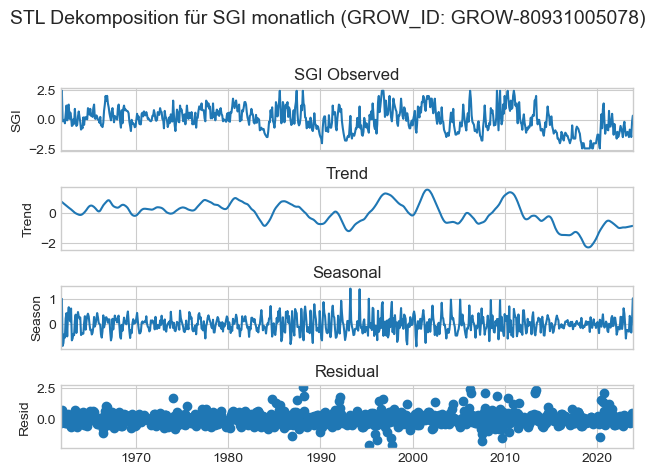

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.40003638 -1.96702501 -1.73938416 -1.57718007 -1.44827204 -1.33974621
 -1.24504624 -1.16036154 -1.08327016 -1.01213103 -0.94577709 -0.88334633
 -0.82418215 -0.7677715  -0.71370464 -0.66164818 -0.61132626 -0.56250721
 -0.51499376 -0.46861583 -0.42322495 -0.37869006 -0.33489417 -0.29173166
 -0.24910613 -0.20692866 -0.16511628 -0.12359072 -0.08227727 -0.04110384
  0.          0.04110384  0.08227727  0.12359072  0.16511628  0.20692866
  0.24910613  0.29173166  0.33489417  0.37869006  0.42322495  0.46861583
  0.51499376  0.56250721  0.61132626  0.66164818  0.71370464  0.7677715
  0.82418215  0.88334633  0.94577709  1.01213103  1.08327016  1.16036154
  1.24504624  1.33974621  1.44827204  1.57718007  1.73938416  1.96702501
  2.40003638]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated an

   Verarbeite Gruppe 80/264: GROW-80931816834


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.40598261 -1.97395292 -1.7469549  -1.58527782 -1.45683732 -1.34874354
 -1.25445294 -1.17016274 -1.0934562  -1.02269598 -0.95671787 -0.8946621
 -0.83587397 -0.77984202 -0.72615797 -0.67448975 -0.62456276 -0.57614655
 -0.52904506 -0.4830894  -0.43813238 -0.39404423 -0.35070929 -0.30802341
 -0.26589175 -0.22422704 -0.18294814 -0.14197877 -0.10124643 -0.06068145
 -0.02021612  0.02021612  0.06068145  0.10124643  0.14197877  0.18294814
  0.22422704  0.26589175  0.30802341  0.35070929  0.39404423  0.43813238
  0.4830894   0.52904506  0.57614655  0.62456276  0.67448975  0.72615797
  0.77984202  0.83587397  0.8946621   0.95671787  1.02269598  1.0934562
  1.17016274  1.25445294  1.34874354  1.45683732  1.58527782  1.7469549
  1.97395292  2.40598261]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is dep

   Verarbeite Gruppe 100/264: GROW-80935336548


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.37510708 -1.93793151 -1.70755309 -1.54309793 -1.41218758 -1.30180675
 -1.20534492 -1.11895838 -1.04020297 -0.96742157 -0.89943491 -0.83537114
 -0.77456543 -0.7164975  -0.66075113 -0.60698683 -0.55492294 -0.50432205
 -0.45498114 -0.40672425 -0.35939683 -0.3128614  -0.26699413 -0.22168205
 -0.17682084 -0.13231285 -0.08806557 -0.04399012  0.          0.04399012
  0.08806557  0.13231285  0.17682084  0.22168205  0.26699413  0.3128614
  0.35939683  0.40672425  0.45498114  0.50432205  0.55492294  0.60698683
  0.66075113  0.7164975   0.77456543  0.83537114  0.89943491  0.96742157
  1.04020297  1.11895838  1.20534492  1.30180675  1.41218758  1.54309793
  1.70755309  1.93793151  2.37510708]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

   Verarbeite Gruppe 120/264: GROW-80937459453


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.3939798  -1.95996398 -1.7316644  -1.56891963 -1.43953147 -1.33056151
 -1.23544034 -1.15034938 -1.07286134 -1.0013313  -0.93458929 -0.87177097
 -0.8122178  -0.75541503 -0.70095142 -0.64849218 -0.59776013 -0.54852228
 -0.50058011 -0.45376219 -0.40791874 -0.3629173  -0.31863936 -0.27497775
 -0.23183436 -0.18911843 -0.14674496 -0.10463346 -0.06270678 -0.02089009
  0.02089009  0.06270678  0.10463346  0.14674496  0.18911843  0.23183436
  0.27497775  0.31863936  0.3629173   0.40791874  0.45376219  0.50058011
  0.54852228  0.59776013  0.64849218  0.70095142  0.75541503  0.8122178
  0.87177097  0.93458929  1.0013313   1.07286134  1.15034938  1.23544034
  1.33056151  1.43953147  1.56891963  1.7316644   1.95996398  2.3939798 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise 

   Verarbeite Gruppe 140/264: GROW-80939756408


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.37510708 -1.93793151 -1.70755309 -1.54309793 -1.41218758 -1.30180675
 -1.20534492 -1.11895838 -1.04020297 -0.96742157 -0.89943491 -0.83537114
 -0.77456543 -0.7164975  -0.66075113 -0.60698683 -0.55492294 -0.50432205
 -0.45498114 -0.40672425 -0.35939683 -0.3128614  -0.26699413 -0.22168205
 -0.17682084 -0.13231285 -0.08806557 -0.04399012  0.          0.04399012
  0.08806557  0.13231285  0.17682084  0.22168205  0.26699413  0.3128614
  0.35939683  0.40672425  0.45498114  0.50432205  0.55492294  0.60698683
  0.66075113  0.7164975   0.77456543  0.83537114  0.89943491  0.96742157
  1.04020297  1.11895838  1.20534492  1.30180675  1.41218758  1.54309793
  1.70755309  1.93793151  2.37510708]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

   Verarbeite Gruppe 160/264: GROW-80942271186


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.3878089  -1.95276492 -1.72378999 -1.56049027 -1.43060877 -1.32118203
 -1.22562724 -1.14011765 -1.0622205  -0.99028692 -0.92314393 -0.85992478
 -0.7999689  -0.7427598  -0.68788465 -0.63500719 -0.58384881 -0.53417518
 -0.48578636 -0.43850955 -0.39219349 -0.34670419 -0.30192155 -0.25773664
 -0.21404948 -0.17076725 -0.12780274 -0.08507296 -0.04249801  0.
  0.04249801  0.08507296  0.12780274  0.17076725  0.21404948  0.25773664
  0.30192155  0.34670419  0.39219349  0.43850955  0.48578636  0.53417518
  0.58384881  0.63500719  0.68788465  0.7427598   0.7999689   0.85992478
  0.92314393  0.99028692  1.0622205   1.14011765  1.22562724  1.32118203
  1.43060877  1.56049027  1.72378999  1.95276492  2.3878089 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a futur

   Verarbeite Gruppe 180/264: GROW-80945357487


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.36856706 -1.93028586 -1.69917766 -1.53412054 -1.40267329 -1.29179378
 -1.19485712 -1.10801082 -1.02880476 -0.95557754 -0.88714656 -0.82263729
 -0.76138261 -0.70286023 -0.64665208 -0.59241694 -0.53987141 -0.48877641
 -0.4389272  -0.39014602 -0.34227645 -0.295179   -0.24872769 -0.20280722
 -0.15731068 -0.11213762 -0.06719235 -0.02238248  0.02238248  0.06719235
  0.11213762  0.15731068  0.20280722  0.24872769  0.295179    0.34227645
  0.39014602  0.4389272   0.48877641  0.53987141  0.59241694  0.64665208
  0.70286023  0.76138261  0.82263729  0.88714656  0.95557754  1.02880476
  1.10801082  1.19485712  1.29179378  1.40267329  1.53412054  1.69917766
  1.93028586  2.36856706]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

   Verarbeite Gruppe 200/264: GROW-80947532792


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.36856706 -1.93028586 -1.69917766 -1.53412054 -1.40267329 -1.29179378
 -1.19485712 -1.10801082 -1.02880476 -0.95557754 -0.88714656 -0.82263729
 -0.76138261 -0.70286023 -0.64665208 -0.59241694 -0.53987141 -0.48877641
 -0.4389272  -0.39014602 -0.34227645 -0.295179   -0.24872769 -0.20280722
 -0.15731068 -0.11213762 -0.06719235 -0.02238248  0.02238248  0.06719235
  0.11213762  0.15731068  0.20280722  0.24872769  0.295179    0.34227645
  0.39014602  0.4389272   0.48877641  0.53987141  0.59241694  0.64665208
  0.70286023  0.76138261  0.82263729  0.88714656  0.95557754  1.02880476
  1.10801082  1.19485712  1.29179378  1.40267329  1.53412054  1.69917766
  1.93028586  2.36856706]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

   Verarbeite Gruppe 220/264: GROW-80950527383


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.36856706 -1.93028586 -1.69917766 -1.53412054 -1.40267329 -1.29179378
 -1.19485712 -1.10801082 -1.02880476 -0.95557754 -0.88714656 -0.82263729
 -0.76138261 -0.70286023 -0.64665208 -0.59241694 -0.53987141 -0.48877641
 -0.4389272  -0.39014602 -0.34227645 -0.295179   -0.24872769 -0.20280722
 -0.15731068 -0.11213762 -0.06719235 -0.02238248  0.02238248  0.06719235
  0.11213762  0.15731068  0.20280722  0.24872769  0.295179    0.34227645
  0.39014602  0.4389272   0.48877641  0.53987141  0.59241694  0.64665208
  0.70286023  0.76138261  0.82263729  0.88714656  0.95557754  1.02880476
  1.10801082  1.19485712  1.29179378  1.40267329  1.53412054  1.69917766
  1.93028586  2.36856706]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

   Verarbeite Gruppe 240/264: GROW-80952921019


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.2692058  -1.81341757 -1.57058503 -1.39574699 -1.25548617 -1.13634082
 -1.03145909 -0.93684711 -0.84995728 -0.76905533 -0.69290035 -0.62056827
 -0.5513477  -0.4846749  -0.42009151 -0.35721583 -0.2957227  -0.23532887
 -0.17578212 -0.11685275 -0.05832674  0.          0.05832674  0.11685275
  0.17578212  0.23532887  0.2957227   0.35721583  0.42009151  0.4846749
  0.5513477   0.62056827  0.69290035  0.76905533  0.84995728  0.93684711
  1.03145909  1.13634082  1.25548617  1.39574699  1.57058503  1.81341757
  2.2692058 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.36856706 -1.93028586 -1.69917766 -1.53412054 -1.40267329 -1.29179378
 -1.19485712 -1.10801082 -1.02880476 -0.95557754 -0.88714656 -0.82263729
 -0.76138261 

   Verarbeite Gruppe 260/264: GROW-80956930857


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.36856706 -1.93028586 -1.69917766 -1.53412054 -1.40267329 -1.29179378
 -1.19485712 -1.10801082 -1.02880476 -0.95557754 -0.88714656 -0.82263729
 -0.76138261 -0.70286023 -0.64665208 -0.59241694 -0.53987141 -0.48877641
 -0.4389272  -0.39014602 -0.34227645 -0.295179   -0.24872769 -0.20280722
 -0.15731068 -0.11213762 -0.06719235 -0.02238248  0.02238248  0.06719235
  0.11213762  0.15731068  0.20280722  0.24872769  0.295179    0.34227645
  0.39014602  0.4389272   0.48877641  0.53987141  0.59241694  0.64665208
  0.70286023  0.76138261  0.82263729  0.88714656  0.95557754  1.02880476
  1.10801082  1.19485712  1.29179378  1.40267329  1.53412054  1.69917766
  1.93028586  2.36856706]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

SGI-Berechnung, SGI-Dekomposition & dynamische Feature-Extraktion für ML abgeschlossen.
Form des ML-Input-DataFrames vor Feature Engineering: (179988, 17)
Starte erweiterte Machine-Learning-Pipeline mit SGI-Dekompositions-Features...
One-Hot Encoding für Spalte: main_landuse
One-Hot Encoding für Spalte: month_num
Form des ML-DataFrames nach One-Hot Encoding: (179988, 48)
Form des ML-DataFrames nach Feature Engineering und selektivem NaN-Drop: (170220, 48)
Split-Jahr für Training/Test: Daten vor 2008 für Training, ab 2008 für Test.
Größe Roh-Trainingsdaten (X_train_raw): (129036, 41)
Größe Roh-Testdaten (X_test_raw): (41184, 41)
Skaliere 27 numerische Features...
Größe finale Trainingsdaten (X_train): (129036, 41)
Größe finale Testdaten (X_test): (41184, 41)
Modell wird mit 129036 Datenpunkten von 264 eindeutigen Zeitreihen (GROW_IDs) trainiert.
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Beste Parameter für LightGBM: {'learning_rate': 0.1, 'n_estimators': 300, 'num_le

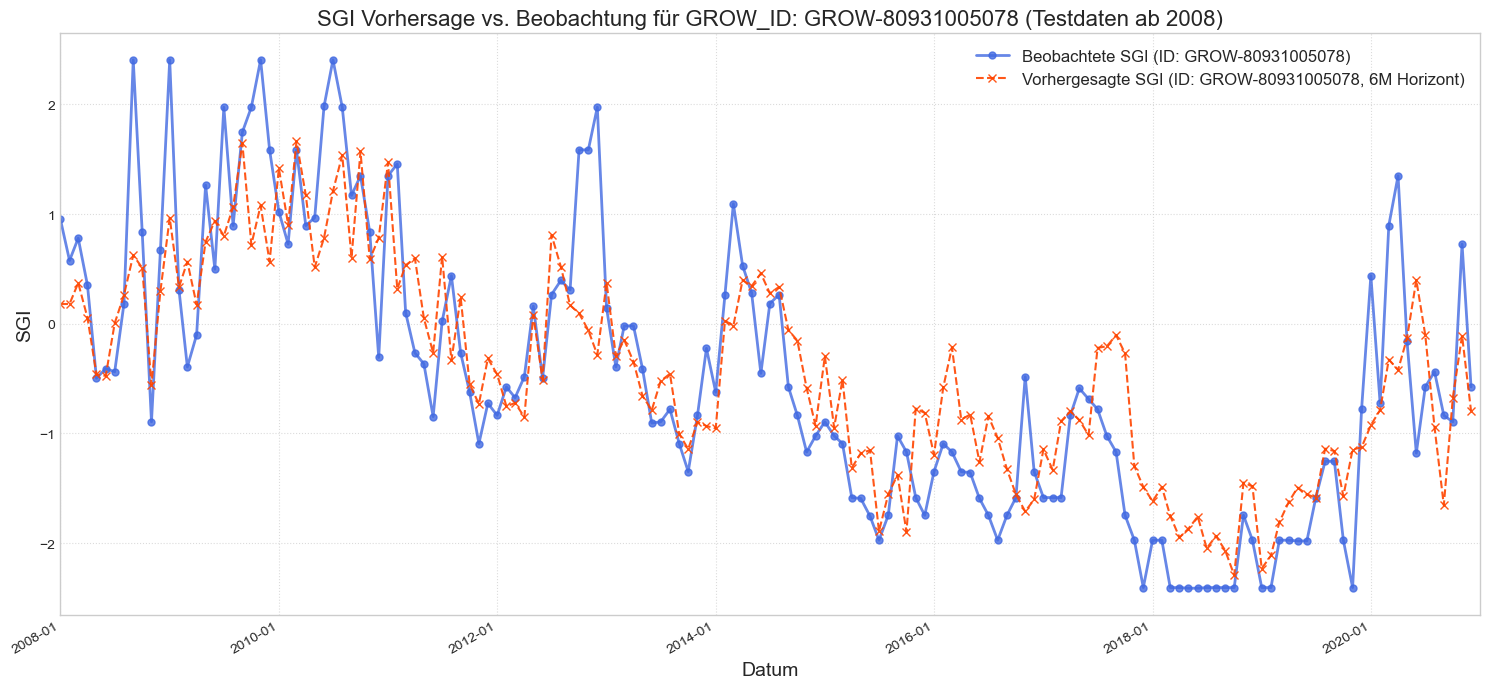

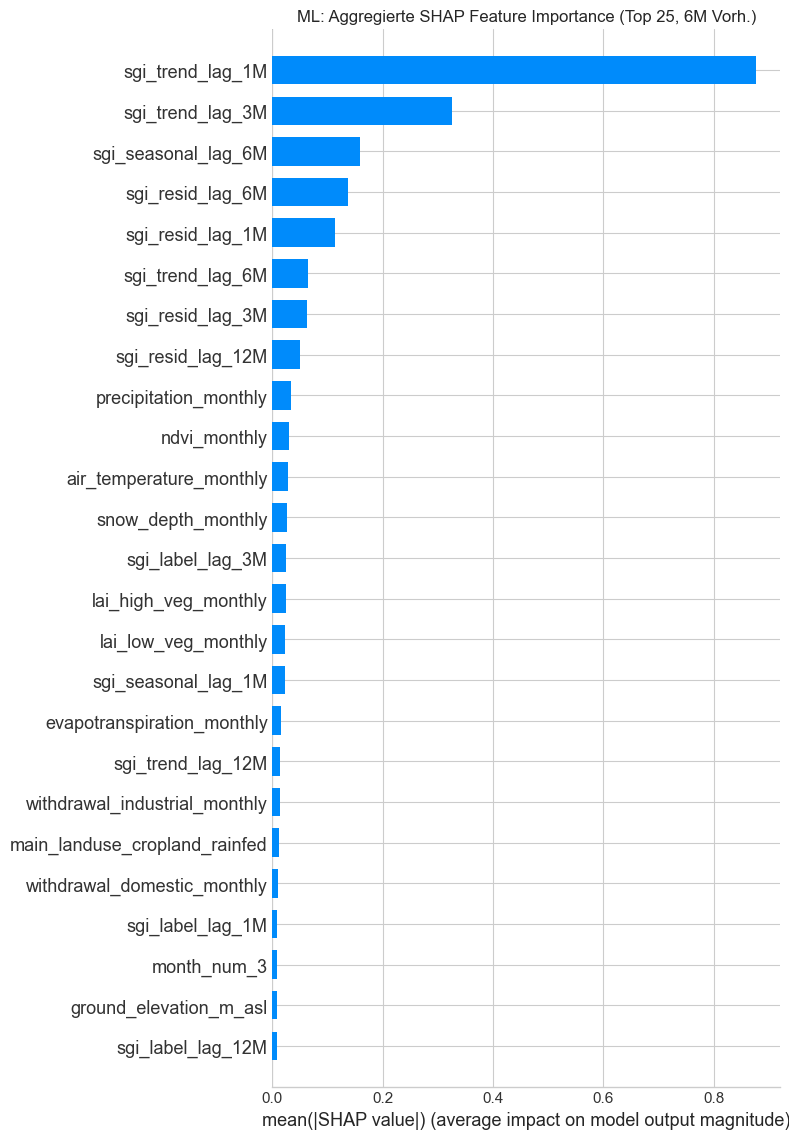

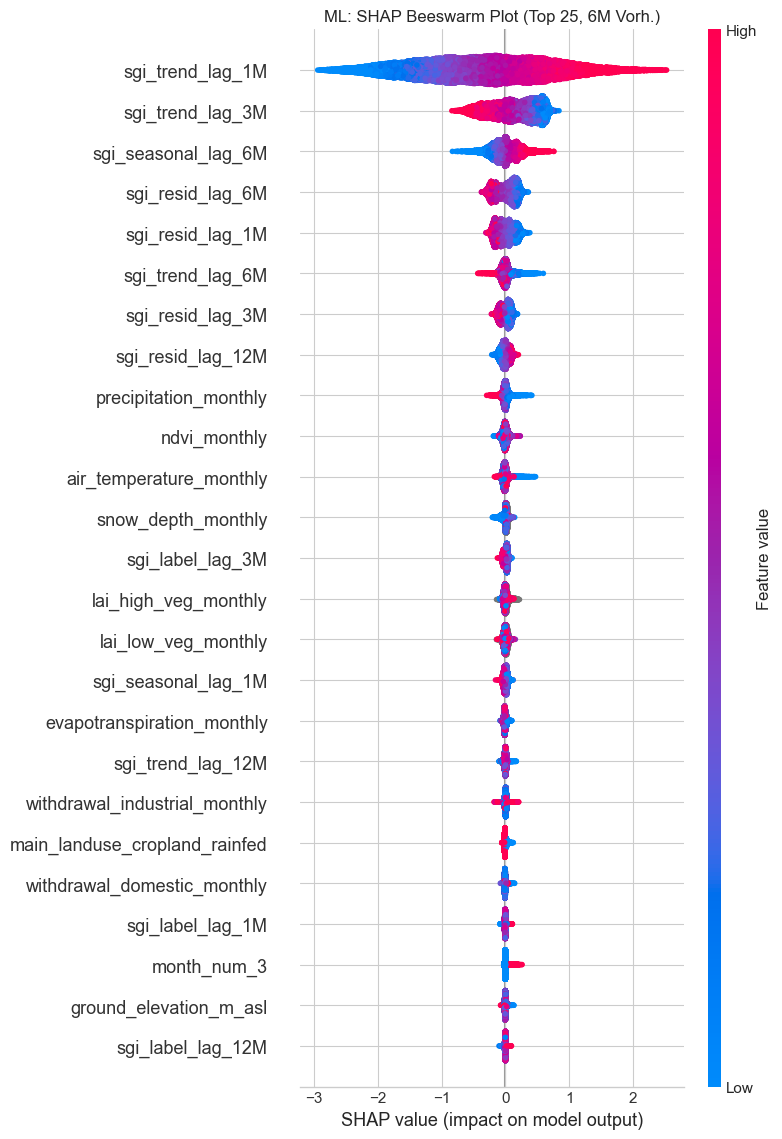

Erweiterte Machine-Learning-Pipeline (SGI-Dekomposition, One-Hot, 6M Vorh.) abgeschlossen.
Speichere Trainings- und Testdaten in CSV-Dateien...
Trainingsdaten gespeichert: train_data.csv mit Shape (129036, 42)
Testdaten gespeichert: test_data.csv mit Shape (41184, 42)
Speichern der Daten abgeschlossen.


In [29]:
# --- TEIL 0: Bibliotheken importieren und Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Für Datumsformatierung
import pastas as ps
import pyarrow.dataset as ds
import lightgbm as lgb
import shap
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import gc # Garbage Collector
from statsmodels.tsa.seasonal import STL # Für Zeitreihen-Dekomposition

# Loglevel für Pastas und LightGBM reduzieren
ps.set_log_level("ERROR")
print("Starte Skript: SGI-Berechnung, SGI-Dekomposition und erweiterte ML-Pipeline")

# --------------------------------------------------------------------------
# Definition der ursprünglichen Feature-Typen aus den Eingabedateien
# --------------------------------------------------------------------------

# Statische Features aus 'grow_attributes.parquet'
STATIC_CATEGORICAL_FEATURES = [
    "main_landuse"  # Nur main_landuse beibehalten
]

STATIC_NUMERICAL_FEATURES = [
    "ground_elevation_m_asl",   # Höhe über dem Meeresspiegel
    "topographic_slope_degrees",# Topographische Neigung
]

# Dynamische Features aus 'grow_timeseries.parquet'
DYNAMIC_NUMERICAL_FEATURES_RAW = [
    "groundwater_level_m_asl",
    "precipitation_gpcc_mm_year-1",
    "potential_evapotranspiration_era5_mm_year-1",
    "air_temperature_°C",
    "snow_depth_m",
    "ndvi_ratio",
    "lai_low_vegetation_ratio",
    "lai_high_vegetation_ratio",
    "withdrawal_industrial_m3_year-1",
    "withdrawal_domestic_m3_year-1"
]

# Globale Variable für den Plot-Status der Dekomposition
decomposition_plot_done = False
target_grow_id_for_decomposition_plot = None # Wird später gesetzt

# --- TEIL 1: Datenauswahl und SGI-Berechnung für das ML-Label & Feature Collection ---
try:
    attr_df_full = pd.read_parquet("Daten/grow_attributes.parquet")
except FileNotFoundError:
    print("Fehler: 'Daten/grow_attributes.parquet' nicht gefunden.")
    raise
except Exception as e:
    print(f"Fehler beim Laden von 'Daten/grow_attributes.parquet': {e}")
    raise

# Datentypen in attr_df frühzeitig optimieren
for col in attr_df_full.select_dtypes(include=['float64']).columns:
    attr_df_full[col] = attr_df_full[col].astype(np.float32)
for col in attr_df_full.select_dtypes(include=['int64']).columns:
    if attr_df_full[col].min() >= np.iinfo(np.int32).min and attr_df_full[col].max() <= np.iinfo(np.int32).max:
        attr_df_full[col] = attr_df_full[col].astype(np.int32)

attr_filtered_df = attr_df_full[
    (attr_df_full["country"] == "CZE") &
    (attr_df_full["length_years"] >= 30) &
    (attr_df_full["gap_fraction"] == 0.0) &
    (pd.to_datetime(attr_df_full["ending_date"]) >= pd.Timestamp("2023-12-01"))
]
print(f"Gefundene Zeitreihen mit Kriterien für ML: {len(attr_filtered_df)}")
if attr_filtered_df.empty:
    raise ValueError("Keine passende Zeitreihe für CZ für ML gefunden.")

target_grow_id_for_decomposition_plot = attr_filtered_df.sort_values("length_years", ascending=False).iloc[0]["GROW_ID"]
print(f"Ziel-GROW_ID für den Dekompositionsplot: {target_grow_id_for_decomposition_plot}")


cz_ids_for_ml = attr_filtered_df["GROW_ID"].dropna().unique().tolist()
print(f"Anzahl eindeutiger GROW_IDs für ML-Datenbasis: {len(cz_ids_for_ml)}")

dynamic_feature_columns_to_load = ["GROW_ID", "date"] + DYNAMIC_NUMERICAL_FEATURES_RAW

try:
    timeseries_dataset_raw = ds.dataset("Daten/grow_timeseries.parquet", format="parquet")
    available_columns_in_parquet = timeseries_dataset_raw.schema.names
    columns_to_actually_load = [col for col in dynamic_feature_columns_to_load if col in available_columns_in_parquet]

    timeseries_table_raw = timeseries_dataset_raw.to_table(
        filter=ds.field("GROW_ID").isin(cz_ids_for_ml),
        columns=columns_to_actually_load
    )
    raw_ts_df_full = timeseries_table_raw.to_pandas(self_destruct=True, split_blocks=True, zero_copy_only=False)
except FileNotFoundError:
    print("Fehler: 'Daten/grow_timeseries.parquet' nicht gefunden.")
    raise
except Exception as e:
    print(f"Fehler beim Laden von Zeitreihen: {e}")
    raise

raw_ts_df_full["date"] = pd.to_datetime(raw_ts_df_full["date"])
if "precipitation_gpcc_mm_year-1" in raw_ts_df_full.columns:
    raw_ts_df_full["precipitation_gpcc_mm_month-1"] = (raw_ts_df_full["precipitation_gpcc_mm_year-1"] / 12).astype(np.float32)
if "potential_evapotranspiration_era5_mm_year-1" in raw_ts_df_full.columns:
    raw_ts_df_full["potential_evapotranspiration_era5_mm_month-1"] = (raw_ts_df_full["potential_evapotranspiration_era5_mm_year-1"] / 12).astype(np.float32)

cols_to_convert_float32 = [
    "groundwater_level_m_asl", "air_temperature_°C", "snow_depth_m", "ndvi_ratio",
    "lai_low_vegetation_ratio", "lai_high_vegetation_ratio",
    "withdrawal_industrial_m3_year-1", "withdrawal_domestic_m3_year-1"
]
for col in cols_to_convert_float32:
    if col in raw_ts_df_full.columns:
        raw_ts_df_full[col] = raw_ts_df_full[col].astype(np.float32)

grouped_ts_data = raw_ts_df_full.set_index('date').groupby('GROW_ID')
del raw_ts_df_full
gc.collect()

all_ml_data_list = []
print(f"Beginne mit SGI-Berechnung, SGI-Dekomposition & Feature-Extraktion für {len(cz_ids_for_ml)} GROW_IDs...")


def process_grow_id_data(grow_id_data, current_grow_id):
    global decomposition_plot_done, target_grow_id_for_decomposition_plot

    gwl_series_raw = grow_id_data["groundwater_level_m_asl"].dropna()
    if gwl_series_raw.empty: return None
    gwl_series_monthly = gwl_series_raw.resample('MS').mean().astype(np.float32)

    if len(gwl_series_monthly.dropna()) < 120: # Mindestens 10 Jahre an monatlichen Daten
        return None

    try:
        sgi_observed_monthly = ps.stats.sgi(gwl_series_monthly)
        if sgi_observed_monthly.empty or sgi_observed_monthly.isnull().all():
            return None
    except Exception as e:
        return None

    sgi_trend = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)
    sgi_seasonal = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)
    sgi_resid = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)

    sgi_for_stl = sgi_observed_monthly.dropna()
    if len(sgi_for_stl) >= 25: # STL benötigt mindestens 2 Periodenzyklen + 1
        try:
            stl = STL(sgi_for_stl, period=12, robust=True)
            res_stl = stl.fit()

            sgi_trend = res_stl.trend.reindex(sgi_observed_monthly.index).astype(np.float32)
            sgi_seasonal = res_stl.seasonal.reindex(sgi_observed_monthly.index).astype(np.float32)
            sgi_resid = res_stl.resid.reindex(sgi_observed_monthly.index).astype(np.float32)

            if current_grow_id == target_grow_id_for_decomposition_plot and not decomposition_plot_done:
                print(f"\nErstelle Dekompositionsplot für SGI (GROW_ID: {current_grow_id})")
                try:
                    fig_stl = res_stl.plot()
                    fig_stl.suptitle(f"STL Dekomposition für SGI monatlich (GROW_ID: {current_grow_id})", fontsize=14)

                    if len(fig_stl.axes) > 0:
                        fig_stl.axes[0].set_title("SGI Observed")
                        fig_stl.axes[0].set_ylabel("SGI")
                    if len(fig_stl.axes) > 1: fig_stl.axes[1].set_title("Trend")
                    if len(fig_stl.axes) > 2: fig_stl.axes[2].set_title("Seasonal")
                    if len(fig_stl.axes) > 3: fig_stl.axes[3].set_title("Residual")

                    plt.tight_layout(rect=[0, 0, 1, 0.96])
                    plt.show()
                    decomposition_plot_done = True
                except Exception as plot_e:
                    print(f"   Fehler beim Erstellen des STL-Plots für {current_grow_id}: {plot_e}")
        except Exception as e_stl:
                print(f"   Fehler bei STL-Dekomposition für GROW_ID {current_grow_id}: {e_stl}.")

    monthly_features_dict = {
        'sgi_label': sgi_observed_monthly,
        'sgi_trend': sgi_trend,
        'sgi_seasonal': sgi_seasonal,
        'sgi_resid': sgi_resid
    }

    dynamic_to_monthly_map = {
        "precipitation_gpcc_mm_month-1": "precipitation_monthly",
        "potential_evapotranspiration_era5_mm_month-1": "evapotranspiration_monthly",
        "air_temperature_°C": "air_temperature_monthly",
        "snow_depth_m": "snow_depth_monthly",
        "ndvi_ratio": "ndvi_monthly",
        "lai_low_vegetation_ratio": "lai_low_veg_monthly",
        "lai_high_vegetation_ratio": "lai_high_veg_monthly"
    }
    for col_name_orig, col_name_target in dynamic_to_monthly_map.items():
        if col_name_orig in grow_id_data.columns:
            feat_series = grow_id_data[col_name_orig].dropna().resample('MS').mean()
            monthly_features_dict[col_name_target] = feat_series.reindex(sgi_observed_monthly.index).astype(np.float32)
        else:
            monthly_features_dict[col_name_target] = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)

    yearly_to_monthly_ffill_map = {
        "withdrawal_industrial_m3_year-1": "withdrawal_industrial_monthly",
        "withdrawal_domestic_m3_year-1": "withdrawal_domestic_monthly"
    }
    for col_name_orig, col_name_target in yearly_to_monthly_ffill_map.items():
        if col_name_orig in grow_id_data.columns:
            feat_series_yearly = grow_id_data[col_name_orig].dropna()
            if not feat_series_yearly.index.is_unique:
                feat_series_yearly = feat_series_yearly[~feat_series_yearly.index.duplicated(keep='first')]
            feat_series_monthly_ffill = feat_series_yearly.resample('MS').ffill()
            monthly_features_dict[col_name_target] = feat_series_monthly_ffill.reindex(sgi_observed_monthly.index).astype(np.float32)
        else:
            monthly_features_dict[col_name_target] = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)

    combined_monthly_df = pd.DataFrame(monthly_features_dict)
    combined_monthly_df.dropna(subset=['sgi_label'], inplace=True)
    return combined_monthly_df

processed_groups = []
for i, (grow_id, group_data) in enumerate(grouped_ts_data):
    if (i + 1) % 20 == 0:
        print(f"   Verarbeite Gruppe {i+1}/{len(grouped_ts_data)}: {grow_id}")
    processed_df = process_grow_id_data(group_data, grow_id)
    if processed_df is not None and not processed_df.empty:
        processed_df['GROW_ID'] = grow_id
        processed_groups.append(processed_df)
del grouped_ts_data
gc.collect()

print("SGI-Berechnung, SGI-Dekomposition & dynamische Feature-Extraktion für ML abgeschlossen.")
if not processed_groups:
    raise ValueError("Keine Daten für ML-Modell nach Verarbeitung.")

df_ml_input_dynamic = pd.concat(processed_groups)
del processed_groups
gc.collect()

static_features_to_select = ["GROW_ID"] + STATIC_NUMERICAL_FEATURES + STATIC_CATEGORICAL_FEATURES
static_features_to_select = [col for col in static_features_to_select if col in attr_df_full.columns]


attr_df_ml_static = attr_df_full[attr_df_full['GROW_ID'].isin(cz_ids_for_ml)][static_features_to_select].copy()
attr_df_ml_static.drop_duplicates(subset=['GROW_ID'], inplace=True, keep='first')
for col in attr_df_ml_static.select_dtypes(include=['float64']).columns:
    attr_df_ml_static[col] = attr_df_ml_static[col].astype(np.float32)

df_ml_input_dynamic.reset_index(inplace=True)
df_ml_input_with_static = pd.merge(df_ml_input_dynamic, attr_df_ml_static, on="GROW_ID", how="left")
df_ml_input_with_static.set_index('date', inplace=True)
df_ml_input = df_ml_input_with_static

del df_ml_input_dynamic, attr_df_ml_static, attr_df_full, attr_filtered_df
gc.collect()

print(f"Form des ML-Input-DataFrames vor Feature Engineering: {df_ml_input.shape}")
if df_ml_input.empty:
    raise ValueError("ML-Input-DataFrame ist leer.")

# --- TEIL 2: Machine-Learning-Pipeline ---
print("Starte erweiterte Machine-Learning-Pipeline mit SGI-Dekompositions-Features...")
df_ml_processed = df_ml_input.copy()
gc.collect()

for lag_col_base in ['sgi_label', 'sgi_trend', 'sgi_seasonal', 'sgi_resid']:
    if lag_col_base not in df_ml_processed.columns:
        print(f"Warnung: Spalte {lag_col_base} nicht in df_ml_processed gefunden. Überspringe Lag-Erstellung dafür.")
        continue
    for lag_val in [1, 3, 6, 12]:
        target_col = f'{lag_col_base}_lag_{lag_val}M'
        df_ml_processed[target_col] = df_ml_processed.groupby('GROW_ID')[lag_col_base].shift(lag_val).astype(np.float32)

df_ml_processed['month_num'] = df_ml_processed.index.month.astype(np.int8)
df_ml_processed['year'] = df_ml_processed.index.year.astype(np.int32)

VORHERSAGE_HORIZONT_MONATE = 6 # Beibehaltung des Horizonts
df_ml_processed[f'sgi_target_{VORHERSAGE_HORIZONT_MONATE}M_future'] = df_ml_processed.groupby('GROW_ID')['sgi_label'].shift(-VORHERSAGE_HORIZONT_MONATE).astype(np.float32)

categorical_cols_to_encode = STATIC_CATEGORICAL_FEATURES + ['month_num']
categorical_cols_to_encode = [col for col in categorical_cols_to_encode if col in df_ml_processed.columns or col == 'month_num']


for col in categorical_cols_to_encode:
    if col in df_ml_processed.columns:
        df_ml_processed[col] = df_ml_processed[col].fillna('Missing').astype(str)

dummy_encoded_cols_list = []
for col_to_encode in categorical_cols_to_encode:
    if col_to_encode in df_ml_processed.columns:
        print(f"One-Hot Encoding für Spalte: {col_to_encode}")
        dummies = pd.get_dummies(df_ml_processed[col_to_encode], prefix=col_to_encode, dummy_na=False, dtype=np.int8)
        df_ml_processed = pd.concat([df_ml_processed, dummies], axis=1)
        df_ml_processed.drop(columns=[col_to_encode], inplace=True)
        dummy_encoded_cols_list.extend(dummies.columns.tolist())
print(f"Form des ML-DataFrames nach One-Hot Encoding: {df_ml_processed.shape}")

# Imputation für statische numerische Features (vor dem Split)
# Dies ist die Logik aus deinem letzten geposteten Code.
# Für eine striktere Vermeidung von Data Leakage sollte der Imputer *nach* dem Split
# *nur auf den Trainingsdaten* gefittet und dann auf Train und Test angewendet werden.
# Aber um die Zeilenzahl-Thematik zu isolieren, behalten wir es hier wie in deinem Code.
numerical_static_cols_for_imputation = [col for col in STATIC_NUMERICAL_FEATURES if col in df_ml_processed.columns]
if numerical_static_cols_for_imputation:
    imputer_numerical_static = SimpleImputer(strategy='median')
    df_ml_processed[numerical_static_cols_for_imputation] = \
        imputer_numerical_static.fit_transform(df_ml_processed[numerical_static_cols_for_imputation]).astype(np.float32)


base_features_ml = [
    "precipitation_monthly", "evapotranspiration_monthly", "air_temperature_monthly",
    "snow_depth_monthly", "ndvi_monthly", "lai_low_veg_monthly", "lai_high_veg_monthly",
    "withdrawal_industrial_monthly", "withdrawal_domestic_monthly"
]
base_features_ml = [col for col in base_features_ml if col in df_ml_processed.columns]

lag_features_sgi_label_ml = [f'sgi_label_lag_{lag}M' for lag in [1, 3, 6, 12] if f'sgi_label_lag_{lag}M' in df_ml_processed.columns]
lag_features_sgi_trend_ml = [f'sgi_trend_lag_{lag}M' for lag in [1, 3, 6, 12] if f'sgi_trend_lag_{lag}M' in df_ml_processed.columns]
lag_features_sgi_seasonal_ml = [f'sgi_seasonal_lag_{lag}M' for lag in [1, 3, 6, 12] if f'sgi_seasonal_lag_{lag}M' in df_ml_processed.columns]
lag_features_sgi_resid_ml = [f'sgi_resid_lag_{lag}M' for lag in [1, 3, 6, 12] if f'sgi_resid_lag_{lag}M' in df_ml_processed.columns]

numerical_static_features_ml = numerical_static_cols_for_imputation # Bereits imputiert

features_columns_ml = list(set( # set zur Vermeidung von Duplikaten
    base_features_ml +
    lag_features_sgi_label_ml +
    lag_features_sgi_trend_ml +
    lag_features_sgi_seasonal_ml +
    lag_features_sgi_resid_ml +
    numerical_static_features_ml +
    dummy_encoded_cols_list
))
features_columns_ml = [col for col in features_columns_ml if col in df_ml_processed.columns] # Finale Prüfung

label_column_ml = f'sgi_target_{VORHERSAGE_HORIZONT_MONATE}M_future'

df_ml_input_for_plot = df_ml_input.copy()
del df_ml_input
gc.collect()

# NaN-Werte entfernen - WICHTIG: DIESE LOGIK WIRD AUS DEINEM LETZTEN CODE ÜBERNOMMEN
# um die Zeilenanzahl konsistent zu halten.
columns_to_check_for_dropna = [label_column_ml, 'sgi_label', 'precipitation_monthly',
                               'evapotranspiration_monthly', 'sgi_label_lag_1M',
                              ] + numerical_static_features_ml # numerical_static_features_ml sind die imputierten STATIC_NUMERICAL_FEATURES
if 'sgi_trend_lag_1M' in features_columns_ml: columns_to_check_for_dropna.append('sgi_trend_lag_1M')
if 'sgi_seasonal_lag_1M' in features_columns_ml: columns_to_check_for_dropna.append('sgi_seasonal_lag_1M')
# Sicherstellen, dass nur existierende Spalten geprüft werden:
columns_to_check_for_dropna = [col for col in columns_to_check_for_dropna if col in df_ml_processed.columns]

df_ml_processed.dropna(subset=columns_to_check_for_dropna, inplace=True)
print(f"Form des ML-DataFrames nach Feature Engineering und selektivem NaN-Drop: {df_ml_processed.shape}")
if df_ml_processed.empty:
    raise ValueError("Keine Daten nach Feature Engineering und NaN-Bereinigung übrig.")

# Daten für das Modell vorbereiten (X und y)
X_all_features_raw = df_ml_processed[features_columns_ml].copy() # Features vor der Skalierung
y_all_labels = df_ml_processed[label_column_ml].copy()
X_meta_for_split = df_ml_processed[['GROW_ID', 'year']].copy()

del df_ml_processed
gc.collect()


# --- TRAIN/TEST SPLIT (ZEITBASIERT - ERFOLGT VOR DER SKALIERUNG) ---
temp_year_series = X_meta_for_split['year']
unique_years_ml = np.sort(temp_year_series.unique())

X_train_raw, X_test_raw = None, None # Roh-Features (noch nicht skaliert)
y_train, y_test = None, None
X_meta_train_ids_info = None # Für Info-Ausgabe, um Verwechslung mit X_meta_test_ids zu vermeiden
X_meta_test_ids = None  # Für Plots und SHAP

if len(unique_years_ml) <= 1:
    print("Warnung: Weniger als 2 Jahre Daten für zeitlichen Split. Nutze zufälligen Split (sortiert) als Fallback.")
    indices = np.arange(len(X_all_features_raw))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, shuffle=False, random_state=42)

    X_train_raw = X_all_features_raw.iloc[train_indices]
    X_test_raw = X_all_features_raw.iloc[test_indices]
    y_train = y_all_labels.iloc[train_indices]
    y_test = y_all_labels.iloc[test_indices]

    X_meta_train_ids_info = X_meta_for_split.iloc[train_indices][['GROW_ID']]
    X_meta_test_ids = X_meta_for_split.iloc[test_indices][['GROW_ID']]
else:
    split_year_index_ml = int(len(unique_years_ml) * 0.8)
    if split_year_index_ml >= len(unique_years_ml): split_year_index_ml = len(unique_years_ml) - 1
    split_year_ml = unique_years_ml[split_year_index_ml if split_year_index_ml > 0 else 0]
    print(f"Split-Jahr für Training/Test: Daten vor {split_year_ml} für Training, ab {split_year_ml} für Test.")

    train_mask_ml = temp_year_series < split_year_ml
    test_mask_ml = temp_year_series >= split_year_ml

    X_train_raw = X_all_features_raw[train_mask_ml]
    X_test_raw = X_all_features_raw[test_mask_ml]
    y_train = y_all_labels[train_mask_ml]
    y_test = y_all_labels[test_mask_ml]

    X_meta_train_ids_info = X_meta_for_split[train_mask_ml][['GROW_ID']]
    X_meta_test_ids = X_meta_for_split[test_mask_ml][['GROW_ID']]

del X_all_features_raw, y_all_labels, temp_year_series, X_meta_for_split
gc.collect()

print(f"Größe Roh-Trainingsdaten (X_train_raw): {X_train_raw.shape}")
print(f"Größe Roh-Testdaten (X_test_raw): {X_test_raw.shape}")

if X_train_raw.empty :
    raise ValueError("Trainingsdatensatz (X_train_raw) nach Split leer.")


# --- SKALIERUNG NUMERISCHER FEATURES (NACH DEM SPLIT) ---
# Identifiziere numerische Features, die skaliert werden sollen
# (ohne die bereits One-Hot-kodierten Dummy-Variablen)
numerical_cols_to_scale = [
    col for col in X_train_raw.columns
    if col not in dummy_encoded_cols_list and \
       X_train_raw[col].dtype in [np.float32, np.float64, np.int32, np.int64, np.int8]
]

X_train = pd.DataFrame(index=X_train_raw.index)
X_test = pd.DataFrame(index=X_test_raw.index) if not X_test_raw.empty else pd.DataFrame(columns=X_train_raw.columns)

if numerical_cols_to_scale:
    scaler = StandardScaler()
    print(f"Skaliere {len(numerical_cols_to_scale)} numerische Features...")

    scaler.fit(X_train_raw[numerical_cols_to_scale])

    scaled_train_values = scaler.transform(X_train_raw[numerical_cols_to_scale])
    X_train_scaled_numerical_df = pd.DataFrame(scaled_train_values, columns=numerical_cols_to_scale, index=X_train_raw.index)
    for col in X_train_scaled_numerical_df.columns:
        X_train[col] = X_train_scaled_numerical_df[col]

    if not X_test_raw.empty:
        # Nur Spalten im Testset skalieren, die auch im Trainingsset skaliert wurden und im Testset existieren
        numerical_cols_to_scale_in_test = [col for col in numerical_cols_to_scale if col in X_test_raw.columns]
        if numerical_cols_to_scale_in_test:
            scaled_test_values = scaler.transform(X_test_raw[numerical_cols_to_scale_in_test])
            X_test_scaled_numerical_df = pd.DataFrame(scaled_test_values, columns=numerical_cols_to_scale_in_test, index=X_test_raw.index)
            for col in X_test_scaled_numerical_df.columns:
                X_test[col] = X_test_scaled_numerical_df[col]
        else:
            print("Warnung: Keine übereinstimmenden numerischen Spalten im Testset zum Skalieren gefunden.")
else:
    print("Keine numerischen Features zum Skalieren im Trainingsset identifiziert.")

# Füge die (nicht-skalierten) Dummy-Variablen hinzu
dummy_cols_in_train = [col for col in dummy_encoded_cols_list if col in X_train_raw.columns]
for col in dummy_cols_in_train:
    X_train[col] = X_train_raw[col]

if not X_test_raw.empty:
    dummy_cols_in_test = [col for col in dummy_encoded_cols_list if col in X_test_raw.columns]
    for col in dummy_cols_in_test:
        X_test[col] = X_test_raw[col]

# Stelle die ursprüngliche Spaltenreihenfolge von `features_columns_ml` sicher
# (oder eine konsistente Teilmenge davon, falls Spalten durch NaN-Filterung komplett entfernt wurden)
final_train_cols = [col for col in features_columns_ml if col in X_train.columns]
X_train = X_train[final_train_cols]

if not X_test.empty:
    final_test_cols = [col for col in features_columns_ml if col in X_test.columns]
    X_test = X_test[final_test_cols]
else:
    X_test = pd.DataFrame(columns=final_train_cols) # Leeres DataFrame mit Spalten des Trainingssets

del X_train_raw
if 'X_test_raw' in locals() and X_test_raw is not None : del X_test_raw
if 'X_train_scaled_numerical_df' in locals(): del X_train_scaled_numerical_df
if 'X_test_scaled_numerical_df' in locals(): del X_test_scaled_numerical_df
gc.collect()

print(f"Größe finale Trainingsdaten (X_train): {X_train.shape}")
print(f"Größe finale Testdaten (X_test): {X_test.shape}")

if X_train.empty :
    raise ValueError("Trainingsdatensatz (X_train) nach Skalierung leer.")

if X_meta_train_ids_info is not None:
    unique_grow_ids_in_train = X_meta_train_ids_info['GROW_ID'].nunique()
    print(f"Modell wird mit {X_train.shape[0]} Datenpunkten von {unique_grow_ids_in_train} eindeutigen Zeitreihen (GROW_IDs) trainiert.")
    del X_meta_train_ids_info
    gc.collect()

# --- MODELL TRAINING UND EVALUATION ---
lgbm_model = lgb.LGBMRegressor(random_state=42, verbosity=-1)
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70]
}

grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, cv=5,
                                scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)
best_lgbm_model = grid_search_lgbm.best_estimator_
print(f"Beste Parameter für LightGBM: {grid_search_lgbm.best_params_}")

if not X_test.empty and not y_test.empty:
    y_pred_ml = best_lgbm_model.predict(X_test)
    y_pred_ml_series = pd.Series(y_pred_ml, index=y_test.index, name="SGI_Predicted")

    r2_ml = r2_score(y_test, y_pred_ml_series)
    rmse_ml = np.sqrt(mean_squared_error(y_test, y_pred_ml_series))
    print(f"R² Score auf Testdaten (Vorhersagehorizont {VORHERSAGE_HORIZONT_MONATE} Monate): {r2_ml:.4f}")
    print(f"RMSE auf Testdaten (Vorhersagehorizont {VORHERSAGE_HORIZONT_MONATE} Monate): {rmse_ml:.4f}")

    # --- Plot: Vorhersage für eine spezifische GROW_ID ---
    if target_grow_id_for_decomposition_plot and X_meta_test_ids is not None:
        mask_target_id_test = X_meta_test_ids['GROW_ID'] == target_grow_id_for_decomposition_plot
        y_test_target_id = y_test[mask_target_id_test]
        y_pred_target_id = y_pred_ml_series[mask_target_id_test]

        if not y_test_target_id.empty:
            fig, ax = plt.subplots(figsize=(15, 7))
            ax.plot(y_test_target_id.index, y_test_target_id.values,
                    label=f'Beobachtete SGI (ID: {target_grow_id_for_decomposition_plot})',
                    marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=5, alpha=0.8)
            ax.plot(y_pred_target_id.index, y_pred_target_id.values,
                    label=f'Vorhergesagte SGI (ID: {target_grow_id_for_decomposition_plot}, {VORHERSAGE_HORIZONT_MONATE}M Horizont)',
                    marker='x', linestyle='--', color='orangered', linewidth=1.5, markersize=6, alpha=0.9)

            start_plot_date = pd.Timestamp("2008-01-01")
            min_date_in_plot = y_test_target_id.index.min() if not y_test_target_id.empty else pd.NaT
            max_date_in_plot = y_test_target_id.index.max() if not y_test_target_id.empty else pd.NaT

            plot_start_lim = max(min_date_in_plot, start_plot_date) if pd.notnull(min_date_in_plot) else start_plot_date
            plot_end_lim = max_date_in_plot + pd.Timedelta(days=30) if pd.notnull(max_date_in_plot) else pd.Timestamp.now()

            ax.set_xlim(left=plot_start_lim, right=plot_end_lim)
            ax.set_title(f'SGI Vorhersage vs. Beobachtung für GROW_ID: {target_grow_id_for_decomposition_plot} (Testdaten ab {plot_start_lim.year if pd.notnull(plot_start_lim) else "N/A"})', fontsize=16)
            ax.set_xlabel('Datum', fontsize=14); ax.set_ylabel('SGI', fontsize=14)
            ax.legend(fontsize=12); ax.grid(True, linestyle=':', alpha=0.7)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); fig.autofmt_xdate()
            plt.style.use('seaborn-v0_8-whitegrid'); plt.tight_layout(); plt.show()
        else:
            print(f"Keine Testdaten für GROW_ID {target_grow_id_for_decomposition_plot} nach Filterung gefunden.")

    # --- SHAP Value Berechnung und Darstellung ---
    try:
        if not X_test.empty and not X_test.dropna(axis=1, how='all').empty:
            explainer_lgbm = shap.TreeExplainer(best_lgbm_model)
            shap_values_lgbm = explainer_lgbm.shap_values(X_test)
            max_display_shap = min(25, len(X_test.columns))

            plt.figure(figsize=(12, int(max(5, 0.2 * max_display_shap)) + 2))
            shap.summary_plot(shap_values_lgbm, X_test, plot_type="bar", show=False, max_display=max_display_shap)
            plt.title(f"ML: Aggregierte SHAP Feature Importance (Top {max_display_shap}, {VORHERSAGE_HORIZONT_MONATE}M Vorh.)")
            plt.tight_layout(); plt.show()

            plt.figure(figsize=(12, int(max(5, 0.2 * max_display_shap)) + 2))
            shap.summary_plot(shap_values_lgbm, X_test, show=False, max_display=max_display_shap)
            plt.title(f"ML: SHAP Beeswarm Plot (Top {max_display_shap}, {VORHERSAGE_HORIZONT_MONATE}M Vorh.)")
            plt.tight_layout(); plt.show()
        else:
            print("X_test ist leer oder enthält keine validen Daten für SHAP-Analyse.")
    except Exception as e:
        print(f"Fehler bei SHAP-Berechnung/Darstellung: {e}")
        if isinstance(e, MemoryError): print("   -> SHAP-Berechnung erfordert möglicherweise zu viel Speicher.")

if 'df_ml_input_for_plot' in locals():
    del df_ml_input_for_plot
    gc.collect()

print(f"Erweiterte Machine-Learning-Pipeline (SGI-Dekomposition, One-Hot, {VORHERSAGE_HORIZONT_MONATE}M Vorh.) abgeschlossen.")


# --- NEU: Speichern von Train- und Testdaten in CSV ---
print("Speichere Trainings- und Testdaten in CSV-Dateien...")

# Speichern von X_train und y_train
train_df_to_save = X_train.copy()
train_df_to_save['sgi_target_label'] = y_train # Füge das Label zu den Features hinzu
train_df_to_save.to_csv("C:/MLmitPython/ML-Python/train_data.csv", index=True) # index=True, um den Zeitstempel zu speichern
print(f"Trainingsdaten gespeichert: train_data.csv mit Shape {train_df_to_save.shape}")

# Speichern von X_test und y_test
if not X_test.empty and not y_test.empty:
    test_df_to_save = X_test.copy()
    test_df_to_save['sgi_target_label'] = y_test # Füge das Label zu den Features hinzu
    test_df_to_save.to_csv("C:/MLmitPython/ML-Python/train_data.csv.csv", index=True) # index=True, um den Zeitstempel zu speichern
    print(f"Testdaten gespeichert: test_data.csv mit Shape {test_df_to_save.shape}")
else:
    print("Testdaten sind leer, daher keine test_data.csv Datei erstellt.")

print("Speichern der Daten abgeschlossen.")
